## Modules

In [13]:
import numpy as np
import pandas as pd
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,SimpleRNN
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [14]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.0
Num GPUs: 1


## Funções Uteis

In [15]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [16]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [17]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [18]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [19]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [20]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [21]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


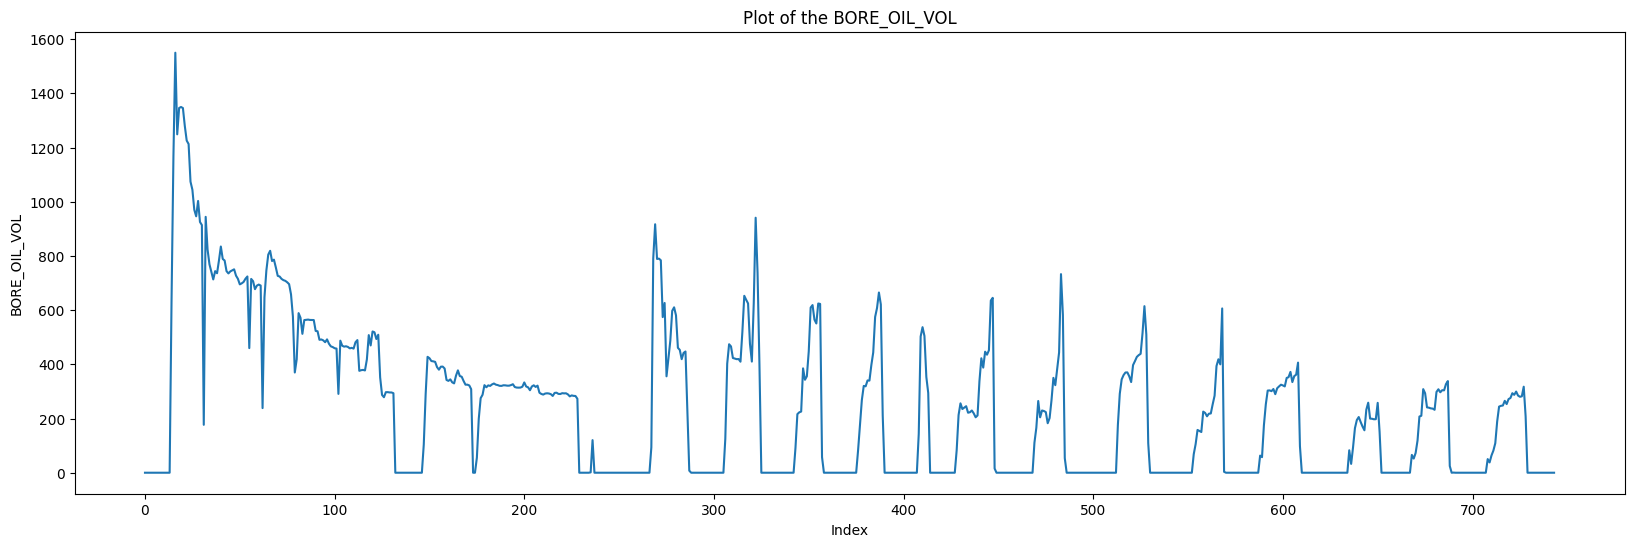

In [22]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [23]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [24]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


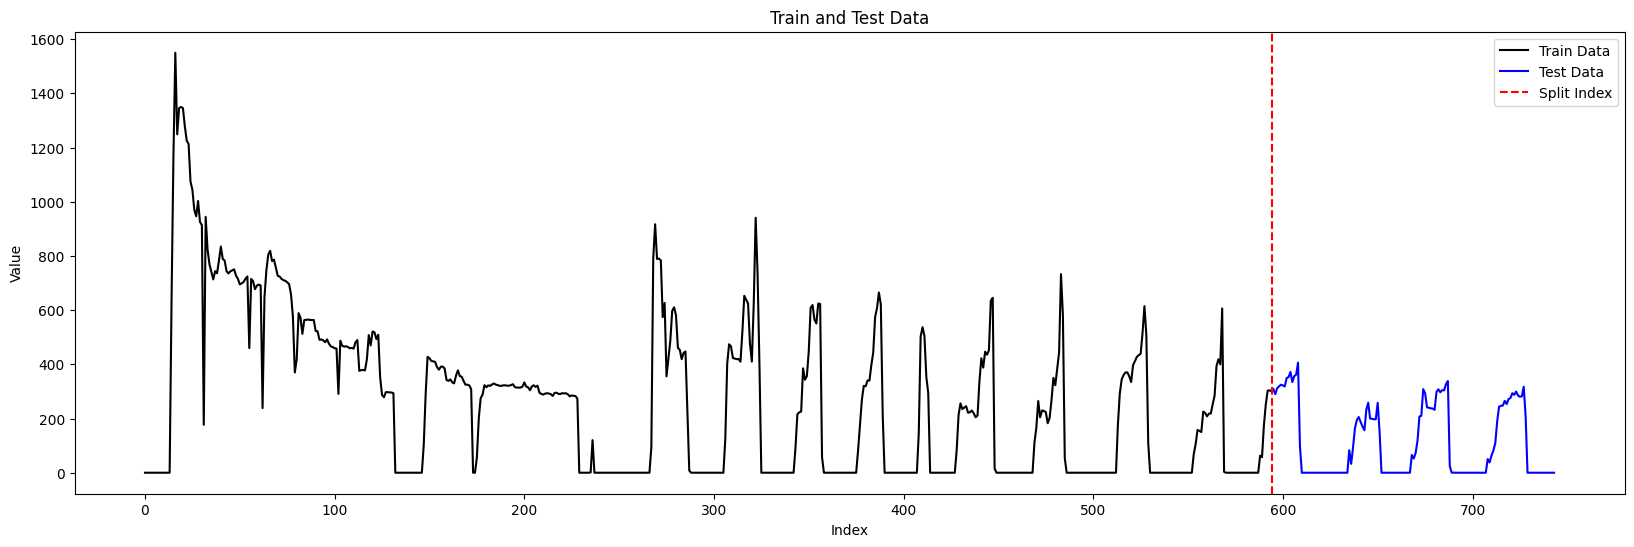

In [25]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [26]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


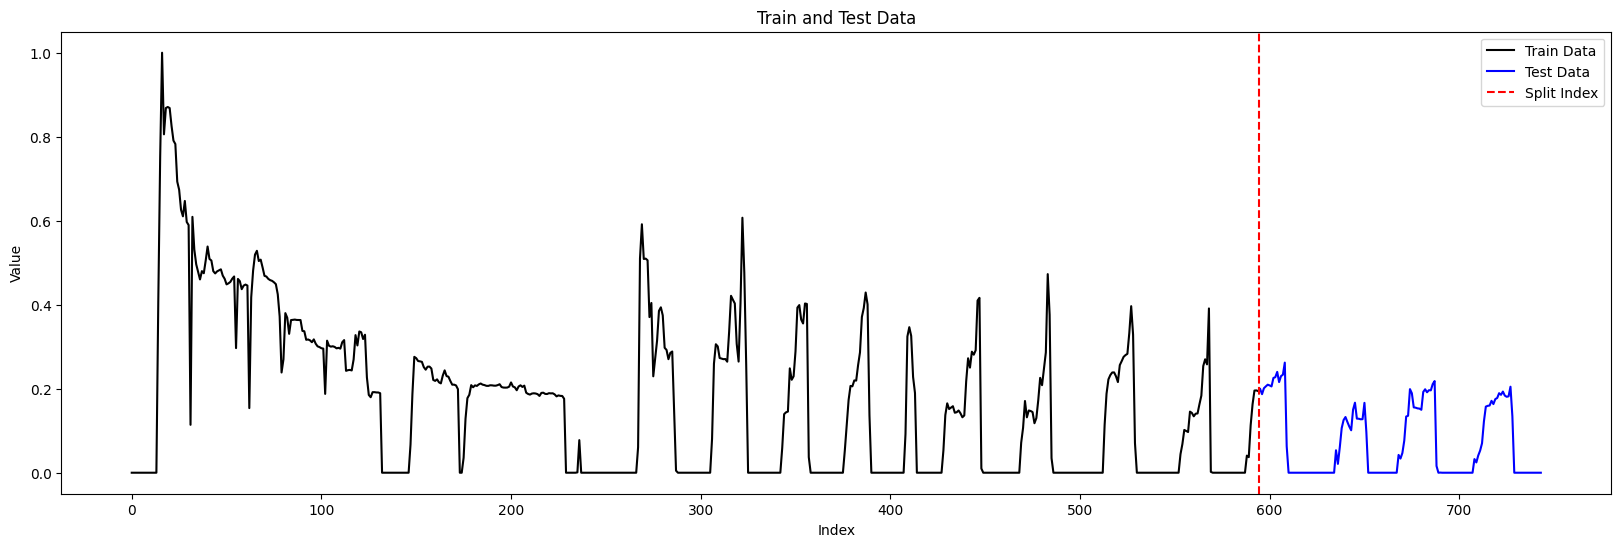

In [62]:
plot_train_test_data(scaled_train, scaled_test, split_index)

## Preparing the X_train, X_test, y_train and y_test

In [27]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [28]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [29]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [30]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [31]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [32]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [33]:
# pip install optuna
!pip install optuna-integration

In [34]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [35]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [36]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('batch_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(SimpleRNN(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
    model_LSTM.add(SimpleRNN(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [37]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2024-01-22 13:05:49,089] A new study created in memory with name: no-name-4ae55609-fcb0-4cd2-9ce4-dd73a0472cc1


In [38]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



INFO:tensorflow:Assets written to: ram://785b723c-e4b9-4def-97b9-88b9932d0769/assets


[I 2024-01-22 13:37:11,896] Trial 0 finished with value: 0.07627803087234497 and parameters: {'window_size': 23, 'batch_size': 20, 'n_lstm_layers': 8, 'lstm_units': 191, 'learning_rate': 0.0044478007812690165}. Best is trial 0 with value: 0.07627803087234497.


INFO:tensorflow:Assets written to: ram://235d8c39-31ed-446f-a26a-f28ebc95b631/assets


[I 2024-01-22 18:07:51,215] Trial 1 finished with value: 0.013561858795583248 and parameters: {'window_size': 33, 'batch_size': 7, 'n_lstm_layers': 18, 'lstm_units': 219, 'learning_rate': 0.0024263433575845888}. Best is trial 1 with value: 0.013561858795583248.


INFO:tensorflow:Assets written to: ram://ed6c563c-f0e4-4e92-b5b9-1fdc58790399/assets


[I 2024-01-22 18:58:05,827] Trial 2 finished with value: 0.009144543670117855 and parameters: {'window_size': 40, 'batch_size': 11, 'n_lstm_layers': 4, 'lstm_units': 218, 'learning_rate': 0.005901877031805708}. Best is trial 2 with value: 0.009144543670117855.


INFO:tensorflow:Assets written to: ram://ff2373eb-75d2-4852-b2fe-634f6d1d8284/assets


[I 2024-01-22 19:15:08,757] Trial 3 finished with value: 0.001576086739078164 and parameters: {'window_size': 3, 'batch_size': 11, 'n_lstm_layers': 19, 'lstm_units': 55, 'learning_rate': 0.0009445852923767603}. Best is trial 3 with value: 0.001576086739078164.


INFO:tensorflow:Assets written to: ram://969aa120-9948-4f18-a08f-b0c6bb7184e3/assets


[I 2024-01-22 20:30:08,131] Trial 4 finished with value: 0.007979312911629677 and parameters: {'window_size': 51, 'batch_size': 20, 'n_lstm_layers': 10, 'lstm_units': 59, 'learning_rate': 0.004091514003816997}. Best is trial 3 with value: 0.001576086739078164.
[I 2024-01-22 20:30:42,359] Trial 5 pruned. 
[I 2024-01-22 20:31:01,868] Trial 6 pruned. 
[I 2024-01-22 20:31:20,653] Trial 7 pruned. 
[I 2024-01-22 20:32:22,174] Trial 8 pruned. 


INFO:tensorflow:Assets written to: ram://c7030b1c-af43-429a-88d7-668a59686e88/assets


[I 2024-01-22 21:23:29,285] Trial 9 finished with value: 0.03345018997788429 and parameters: {'window_size': 12, 'batch_size': 2, 'n_lstm_layers': 2, 'lstm_units': 181, 'learning_rate': 0.0007892975894056115}. Best is trial 3 with value: 0.001576086739078164.


INFO:tensorflow:Assets written to: ram://50a9f0ba-def0-4fa9-9d78-0d0cb08f9bf7/assets


[I 2024-01-22 21:30:07,598] Trial 10 finished with value: 0.0011186664924025536 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 14, 'lstm_units': 33, 'learning_rate': 0.00010984157791689756}. Best is trial 10 with value: 0.0011186664924025536.


INFO:tensorflow:Assets written to: ram://63740565-8281-46af-82de-e61d1ce9ba02/assets


[I 2024-01-22 21:36:48,087] Trial 11 finished with value: 0.0013507683761417866 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 14, 'lstm_units': 39, 'learning_rate': 0.0003637048057432892}. Best is trial 10 with value: 0.0011186664924025536.


INFO:tensorflow:Assets written to: ram://238b35e6-9aa3-46ee-831b-1c7e53c5de27/assets


[I 2024-01-22 21:43:12,538] Trial 12 finished with value: 0.0013243849389255047 and parameters: {'window_size': 2, 'batch_size': 15, 'n_lstm_layers': 14, 'lstm_units': 94, 'learning_rate': 0.0005940596409753345}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 21:43:20,537] Trial 13 pruned. 
[I 2024-01-22 21:43:35,962] Trial 14 pruned. 
[I 2024-01-22 21:43:50,856] Trial 15 pruned. 
[I 2024-01-22 21:43:59,514] Trial 16 pruned. 
[I 2024-01-22 21:44:32,433] Trial 17 pruned. 
[I 2024-01-22 21:44:40,964] Trial 18 pruned. 
[I 2024-01-22 21:45:00,855] Trial 19 pruned. 
[I 2024-01-22 21:45:12,636] Trial 20 pruned. 
[I 2024-01-22 21:45:44,567] Trial 21 pruned. 


INFO:tensorflow:Assets written to: ram://129f4be3-6cd8-43f6-86f2-75795eadab13/assets


[I 2024-01-22 21:52:29,068] Trial 22 finished with value: 0.0011503970017656684 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 12, 'lstm_units': 253, 'learning_rate': 0.00014501007257425725}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 21:52:37,437] Trial 23 pruned. 


INFO:tensorflow:Assets written to: ram://f83dd82a-dd6f-4697-b33a-3dbd20391d17/assets


[I 2024-01-22 22:07:53,991] Trial 24 finished with value: 0.025893596932291985 and parameters: {'window_size': 2, 'batch_size': 6, 'n_lstm_layers': 13, 'lstm_units': 247, 'learning_rate': 0.001574837083910899}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 22:08:01,656] Trial 25 pruned. 
[I 2024-01-22 22:08:12,339] Trial 26 pruned. 
[I 2024-01-22 22:08:25,407] Trial 27 pruned. 
[I 2024-01-22 22:08:51,241] Trial 28 pruned. 
[I 2024-01-22 22:08:57,184] Trial 29 pruned. 
[I 2024-01-22 22:09:21,254] Trial 30 pruned. 
[I 2024-01-22 22:09:30,179] Trial 31 pruned. 
[I 2024-01-22 22:09:37,669] Trial 32 pruned. 
[I 2024-01-22 22:09:42,365] Trial 33 pruned. 
[I 2024-01-22 22:09:51,825] Trial 34 pruned. 
[I 2024-01-22 22:09:57,156] Trial 35 pruned. 


INFO:tensorflow:Assets written to: ram://f31b3495-b28e-4f57-bcfa-d6dcfd7d91c5/assets


[I 2024-01-22 22:14:32,892] Trial 36 finished with value: 0.0020308990497142076 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 9, 'lstm_units': 45, 'learning_rate': 0.0020070287764621286}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 22:14:46,745] Trial 37 pruned. 
[I 2024-01-22 22:15:06,088] Trial 38 pruned. 
[I 2024-01-22 22:15:11,892] Trial 39 pruned. 
[I 2024-01-22 22:15:23,277] Trial 40 pruned. 


INFO:tensorflow:Assets written to: ram://31fa42f0-21ce-4a07-bdbb-ae0fe9cc8176/assets


[I 2024-01-22 22:25:30,653] Trial 41 finished with value: 0.0014887790894135833 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 20, 'lstm_units': 52, 'learning_rate': 0.000994498175005802}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 22:25:40,923] Trial 42 pruned. 
[I 2024-01-22 22:25:51,089] Trial 43 pruned. 
[I 2024-01-22 22:26:04,910] Trial 44 pruned. 
[I 2024-01-22 22:26:09,069] Trial 45 pruned. 
[I 2024-01-22 22:26:17,676] Trial 46 pruned. 
[I 2024-01-22 22:26:20,732] Trial 47 pruned. 
[I 2024-01-22 22:26:41,433] Trial 48 pruned. 
[I 2024-01-22 22:26:56,904] Trial 49 pruned. 
[I 2024-01-22 22:27:04,058] Trial 50 pruned. 


INFO:tensorflow:Assets written to: ram://9b36aa8d-cbec-467b-ad01-a5eaf2996b57/assets


[I 2024-01-22 22:38:24,477] Trial 51 finished with value: 0.004823939874768257 and parameters: {'window_size': 2, 'batch_size': 11, 'n_lstm_layers': 19, 'lstm_units': 67, 'learning_rate': 0.0011083080542658831}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 22:38:35,850] Trial 52 pruned. 
[I 2024-01-22 22:38:45,694] Trial 53 pruned. 
[I 2024-01-22 22:38:51,697] Trial 54 pruned. 
[I 2024-01-22 22:39:54,538] Trial 55 pruned. 
[I 2024-01-22 22:40:07,670] Trial 56 pruned. 
[I 2024-01-22 22:40:25,399] Trial 57 pruned. 
[I 2024-01-22 22:40:50,247] Trial 58 pruned. 
[I 2024-01-22 22:41:20,692] Trial 59 pruned. 
[I 2024-01-22 22:41:28,721] Trial 60 pruned. 


INFO:tensorflow:Assets written to: ram://7f5e996d-3d81-46dc-a89c-1521499698c6/assets


[I 2024-01-22 22:45:35,475] Trial 61 finished with value: 0.0014079809188842773 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 8, 'lstm_units': 43, 'learning_rate': 0.002071015893239385}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 22:45:40,746] Trial 62 pruned. 
[I 2024-01-22 22:45:44,156] Trial 63 pruned. 
[I 2024-01-22 22:45:50,851] Trial 64 pruned. 
[I 2024-01-22 22:45:54,263] Trial 65 pruned. 
[I 2024-01-22 22:46:08,230] Trial 66 pruned. 
[I 2024-01-22 22:46:09,976] Trial 67 pruned. 
[I 2024-01-22 22:46:15,095] Trial 68 pruned. 
[I 2024-01-22 22:46:23,717] Trial 69 pruned. 
[I 2024-01-22 22:46:32,485] Trial 70 pruned. 
[I 2024-01-22 22:46:36,140] Trial 71 pruned. 
[I 2024-01-22 22:46:40,041] Trial 72 pruned. 


INFO:tensorflow:Assets written to: ram://46be889e-3d1b-4f90-9622-ad50fba6f8ea/assets


[I 2024-01-22 22:49:54,461] Trial 73 finished with value: 0.001156730460934341 and parameters: {'window_size': 6, 'batch_size': 12, 'n_lstm_layers': 1, 'lstm_units': 67, 'learning_rate': 0.0009352124088861369}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 22:50:02,221] Trial 74 pruned. 
[I 2024-01-22 22:50:03,672] Trial 75 pruned. 
[I 2024-01-22 22:50:05,926] Trial 76 pruned. 
[I 2024-01-22 22:50:08,419] Trial 77 pruned. 
[I 2024-01-22 22:50:11,049] Trial 78 pruned. 
[I 2024-01-22 22:50:21,053] Trial 79 pruned. 
[I 2024-01-22 22:50:27,816] Trial 80 pruned. 
[I 2024-01-22 22:50:31,678] Trial 81 pruned. 
[I 2024-01-22 22:50:34,688] Trial 82 pruned. 
[I 2024-01-22 22:50:42,606] Trial 83 pruned. 
[I 2024-01-22 22:50:47,595] Trial 84 pruned. 
[I 2024-01-22 22:50:54,404] Trial 85 pruned. 
[I 2024-01-22 22:51:04,126] Trial 86 pruned. 
[I 2024-01-22 22:51:35,191] Trial 87 pruned. 
[I 2024-01-22 22:51:40,770] Trial 88 pruned. 
[I 2024-01-22 22:51:48,599] Trial 89 pruned. 
[

INFO:tensorflow:Assets written to: ram://ffc97675-2cd5-47e0-9585-10d50cb9c2af/assets


[I 2024-01-22 23:03:20,128] Trial 91 finished with value: 0.007675049360841513 and parameters: {'window_size': 2, 'batch_size': 11, 'n_lstm_layers': 19, 'lstm_units': 69, 'learning_rate': 0.0011180590681851665}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:03:28,976] Trial 92 pruned. 
[I 2024-01-22 23:03:40,966] Trial 93 pruned. 
[I 2024-01-22 23:03:48,946] Trial 94 pruned. 
[I 2024-01-22 23:03:55,915] Trial 95 pruned. 
[I 2024-01-22 23:04:02,967] Trial 96 pruned. 
[I 2024-01-22 23:04:14,028] Trial 97 pruned. 
[I 2024-01-22 23:04:19,818] Trial 98 pruned. 
[I 2024-01-22 23:04:39,173] Trial 99 pruned. 
[I 2024-01-22 23:04:47,767] Trial 100 pruned. 
[I 2024-01-22 23:04:56,301] Trial 101 pruned. 
[I 2024-01-22 23:05:04,109] Trial 102 pruned. 
[I 2024-01-22 23:05:23,582] Trial 103 pruned. 
[I 2024-01-22 23:05:32,158] Trial 104 pruned. 
[I 2024-01-22 23:05:37,781] Trial 105 pruned. 
[I 2024-01-22 23:05:38,771] Trial 106 pruned. 
[I 2024-01-22 23:05:43,703] Trial 107 p

INFO:tensorflow:Assets written to: ram://bfb5912f-260f-46a4-82a3-5f76b7acf2d7/assets


[I 2024-01-22 23:18:20,872] Trial 108 finished with value: 0.001844968879595399 and parameters: {'window_size': 2, 'batch_size': 4, 'n_lstm_layers': 7, 'lstm_units': 35, 'learning_rate': 0.0012482858261447006}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:18:32,780] Trial 109 pruned. 
[I 2024-01-22 23:18:39,272] Trial 110 pruned. 
[I 2024-01-22 23:18:41,596] Trial 111 pruned. 
[I 2024-01-22 23:18:45,402] Trial 112 pruned. 
[I 2024-01-22 23:18:56,332] Trial 113 pruned. 
[I 2024-01-22 23:18:59,989] Trial 114 pruned. 
[I 2024-01-22 23:19:04,244] Trial 115 pruned. 
[I 2024-01-22 23:19:12,312] Trial 116 pruned. 
[I 2024-01-22 23:19:19,810] Trial 117 pruned. 
[I 2024-01-22 23:19:21,491] Trial 118 pruned. 
[I 2024-01-22 23:19:32,450] Trial 119 pruned. 
[I 2024-01-22 23:19:56,596] Trial 120 pruned. 
[I 2024-01-22 23:20:15,366] Trial 121 pruned. 
[I 2024-01-22 23:20:28,438] Trial 122 pruned. 
[I 2024-01-22 23:20:37,959] Trial 123 pruned. 
[I 2024-01-22 23:20:54,653] Tria

INFO:tensorflow:Assets written to: ram://0712cc3f-d7e9-4813-88a3-cb01981c258c/assets


[I 2024-01-22 23:26:24,473] Trial 140 finished with value: 0.0016009145183488727 and parameters: {'window_size': 2, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 53, 'learning_rate': 0.006760767829928579}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:26:25,564] Trial 141 pruned. 
[I 2024-01-22 23:26:37,965] Trial 142 pruned. 


INFO:tensorflow:Assets written to: ram://14aa9a06-f504-4044-992a-04b13afbe6dc/assets


[I 2024-01-22 23:28:19,760] Trial 143 finished with value: 0.0019110305001959205 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 2, 'lstm_units': 55, 'learning_rate': 0.007184019283982429}. Best is trial 10 with value: 0.0011186664924025536.


INFO:tensorflow:Assets written to: ram://8d61f06a-1e78-44e2-978f-41c0ca1bbe5e/assets


[I 2024-01-22 23:30:26,094] Trial 144 finished with value: 0.004443982616066933 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 3, 'lstm_units': 56, 'learning_rate': 0.007538556339520178}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:30:27,589] Trial 145 pruned. 
[I 2024-01-22 23:30:29,062] Trial 146 pruned. 
[I 2024-01-22 23:30:30,593] Trial 147 pruned. 


INFO:tensorflow:Assets written to: ram://037e8c8e-a4d6-40d2-9eb9-a0b5f6d2b04b/assets


[I 2024-01-22 23:32:28,510] Trial 148 finished with value: 0.0013279502745717764 and parameters: {'window_size': 2, 'batch_size': 15, 'n_lstm_layers': 3, 'lstm_units': 37, 'learning_rate': 0.007250920504894067}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:32:30,265] Trial 149 pruned. 
[I 2024-01-22 23:32:31,966] Trial 150 pruned. 
[I 2024-01-22 23:32:33,551] Trial 151 pruned. 
[I 2024-01-22 23:32:34,567] Trial 152 pruned. 


INFO:tensorflow:Assets written to: ram://159a1a0c-4a66-49d8-8007-a7f9ce6b4888/assets


[I 2024-01-22 23:34:16,368] Trial 153 finished with value: 0.0031078846659511328 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 2, 'lstm_units': 54, 'learning_rate': 0.006975433226403082}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:34:18,655] Trial 154 pruned. 
[I 2024-01-22 23:34:19,934] Trial 155 pruned. 
[I 2024-01-22 23:34:22,280] Trial 156 pruned. 
[I 2024-01-22 23:34:23,346] Trial 157 pruned. 
[I 2024-01-22 23:34:25,050] Trial 158 pruned. 
[I 2024-01-22 23:34:26,584] Trial 159 pruned. 
[I 2024-01-22 23:34:27,523] Trial 160 pruned. 


INFO:tensorflow:Assets written to: ram://b2935408-4331-444c-a4db-2fcd4846bac2/assets


[I 2024-01-22 23:36:04,098] Trial 161 finished with value: 0.0013491270365193486 and parameters: {'window_size': 2, 'batch_size': 15, 'n_lstm_layers': 2, 'lstm_units': 66, 'learning_rate': 0.007289730640269065}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:36:05,659] Trial 162 pruned. 
[I 2024-01-22 23:36:07,142] Trial 163 pruned. 
[I 2024-01-22 23:36:08,747] Trial 164 pruned. 
[I 2024-01-22 23:36:09,886] Trial 165 pruned. 
[I 2024-01-22 23:36:12,225] Trial 166 pruned. 
[I 2024-01-22 23:36:13,775] Trial 167 pruned. 
[I 2024-01-22 23:36:19,333] Trial 168 pruned. 
[I 2024-01-22 23:36:25,434] Trial 169 pruned. 
[I 2024-01-22 23:36:27,286] Trial 170 pruned. 


INFO:tensorflow:Assets written to: ram://193742ed-bf86-4c23-8f05-09cb365bfa29/assets


[I 2024-01-22 23:46:53,619] Trial 171 finished with value: 0.0011964396107941866 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 20, 'lstm_units': 68, 'learning_rate': 0.0005521844082597614}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:47:08,001] Trial 172 pruned. 
[I 2024-01-22 23:47:16,641] Trial 173 pruned. 


INFO:tensorflow:Assets written to: ram://abf5ac3f-66cf-49de-9e11-6d931d498d57/assets


[I 2024-01-22 23:56:15,386] Trial 174 finished with value: 0.0011211688397452235 and parameters: {'window_size': 2, 'batch_size': 15, 'n_lstm_layers': 20, 'lstm_units': 62, 'learning_rate': 0.00026998344622490024}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-22 23:56:23,722] Trial 175 pruned. 
[I 2024-01-22 23:56:33,139] Trial 176 pruned. 
[I 2024-01-22 23:56:34,600] Trial 177 pruned. 
[I 2024-01-22 23:56:43,117] Trial 178 pruned. 
[I 2024-01-22 23:56:44,102] Trial 179 pruned. 
[I 2024-01-22 23:56:45,843] Trial 180 pruned. 
[I 2024-01-22 23:56:53,593] Trial 181 pruned. 
[I 2024-01-22 23:57:01,894] Trial 182 pruned. 
[I 2024-01-22 23:57:10,436] Trial 183 pruned. 


INFO:tensorflow:Assets written to: ram://b0a6eb69-5ba6-4822-927d-137def62a9b0/assets


[I 2024-01-23 00:12:13,101] Trial 184 finished with value: 0.0017786358948796988 and parameters: {'window_size': 2, 'batch_size': 5, 'n_lstm_layers': 13, 'lstm_units': 57, 'learning_rate': 0.000666434107497579}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-23 00:12:22,214] Trial 185 pruned. 
[I 2024-01-23 00:12:36,529] Trial 186 pruned. 
[I 2024-01-23 00:13:03,188] Trial 187 pruned. 
[I 2024-01-23 00:13:09,372] Trial 188 pruned. 
[I 2024-01-23 00:13:15,326] Trial 189 pruned. 
[I 2024-01-23 00:13:17,398] Trial 190 pruned. 
[I 2024-01-23 00:13:23,377] Trial 191 pruned. 
[I 2024-01-23 00:13:29,304] Trial 192 pruned. 
[I 2024-01-23 00:13:37,396] Trial 193 pruned. 
[I 2024-01-23 00:13:38,494] Trial 194 pruned. 
[I 2024-01-23 00:13:47,744] Trial 195 pruned. 
[I 2024-01-23 00:13:52,878] Trial 196 pruned. 
[I 2024-01-23 00:14:00,370] Trial 197 pruned. 
[I 2024-01-23 00:14:09,588] Trial 198 pruned. 
[I 2024-01-23 00:14:24,019] Trial 199 pruned. 
[I 2024-01-23 00:14:26,234] Tri

INFO:tensorflow:Assets written to: ram://dd435699-cd17-4dcf-b078-902e2c46b452/assets


[I 2024-01-23 00:20:52,914] Trial 230 finished with value: 0.0011487260926514864 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 2, 'lstm_units': 52, 'learning_rate': 0.0008487752114972912}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-23 00:20:54,535] Trial 231 pruned. 
[I 2024-01-23 00:21:03,563] Trial 232 pruned. 


INFO:tensorflow:Assets written to: ram://dca7afbd-f5dc-47e7-ae6f-fbc9489ecc55/assets


[I 2024-01-23 00:23:26,657] Trial 233 finished with value: 0.001136049279011786 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 62, 'learning_rate': 0.0011702767275221329}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-23 00:23:27,838] Trial 234 pruned. 


INFO:tensorflow:Assets written to: ram://ef85f177-01da-48a9-9e8a-77a348cbefb6/assets


[I 2024-01-23 00:25:52,003] Trial 235 finished with value: 0.001148922136053443 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 63, 'learning_rate': 0.001066527471369864}. Best is trial 10 with value: 0.0011186664924025536.


INFO:tensorflow:Assets written to: ram://47215033-6599-4663-a35d-dfd9854cbba5/assets


[I 2024-01-23 00:28:15,066] Trial 236 finished with value: 0.0011582308216020465 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 62, 'learning_rate': 0.0008647574774644148}. Best is trial 10 with value: 0.0011186664924025536.


INFO:tensorflow:Assets written to: ram://8f10e09e-fe68-417f-885a-4d22edb0899a/assets


[I 2024-01-23 00:31:03,052] Trial 237 finished with value: 0.0011388009879738092 and parameters: {'window_size': 2, 'batch_size': 6, 'n_lstm_layers': 1, 'lstm_units': 63, 'learning_rate': 0.0010332586782220991}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-23 00:31:07,647] Trial 238 pruned. 


INFO:tensorflow:Assets written to: ram://cb1d5ada-35c3-4188-b349-9ba48b3bf896/assets


[I 2024-01-23 00:33:31,093] Trial 239 finished with value: 0.0011749189579859376 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 60, 'learning_rate': 0.0007715733118240208}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-23 00:33:32,274] Trial 240 pruned. 


INFO:tensorflow:Assets written to: ram://e28e1d9c-82b8-42fa-84b9-7c02a225f4c7/assets


[I 2024-01-23 00:35:56,033] Trial 241 finished with value: 0.0011601136066019535 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 58, 'learning_rate': 0.0011013403797939156}. Best is trial 10 with value: 0.0011186664924025536.


INFO:tensorflow:Assets written to: ram://47ba86d4-93cc-4dae-9897-4f756c3bbff7/assets


[I 2024-01-23 00:38:19,836] Trial 242 finished with value: 0.0011546921450644732 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 58, 'learning_rate': 0.001002021918126845}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-23 00:38:21,099] Trial 243 pruned. 


INFO:tensorflow:Assets written to: ram://a985744d-15ed-42c6-bf79-5b365c198fc8/assets


[I 2024-01-23 00:40:46,539] Trial 244 finished with value: 0.0011551430216059089 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 60, 'learning_rate': 0.0009811712225045862}. Best is trial 10 with value: 0.0011186664924025536.


INFO:tensorflow:Assets written to: ram://f52592bc-d037-4a09-b366-c1f311f7cebf/assets


[I 2024-01-23 00:43:11,445] Trial 245 finished with value: 0.0011468810262158513 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 58, 'learning_rate': 0.0010236228624261852}. Best is trial 10 with value: 0.0011186664924025536.


INFO:tensorflow:Assets written to: ram://d76311bb-0c16-482d-910d-f75eb95717d6/assets


[I 2024-01-23 00:45:36,028] Trial 246 finished with value: 0.0011419758666306734 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 62, 'learning_rate': 0.0010084611317889396}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-23 00:45:40,695] Trial 247 pruned. 


INFO:tensorflow:Assets written to: ram://77bb8ff8-9d7d-40f7-a679-307c278e2d10/assets


[I 2024-01-23 00:48:05,748] Trial 248 finished with value: 0.0011622332967817783 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 68, 'learning_rate': 0.0008595731157090276}. Best is trial 10 with value: 0.0011186664924025536.
[I 2024-01-23 00:48:06,996] Trial 249 pruned. 


In [39]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 14, 'lstm_units': 33, 'learning_rate': 0.00010984157791689756}
Best Validation Loss: 0.0011186664924025536


In [40]:
study.best_params['n_lstm_layers']

14

In [41]:
study.best_trial.number

10

In [42]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['batch_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']


# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(SimpleRNN(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
best_model_LSTM.add(SimpleRNN(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [43]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 5ms/step


In [44]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.005288386680644499
Test MSE: 0.0011173762572229678


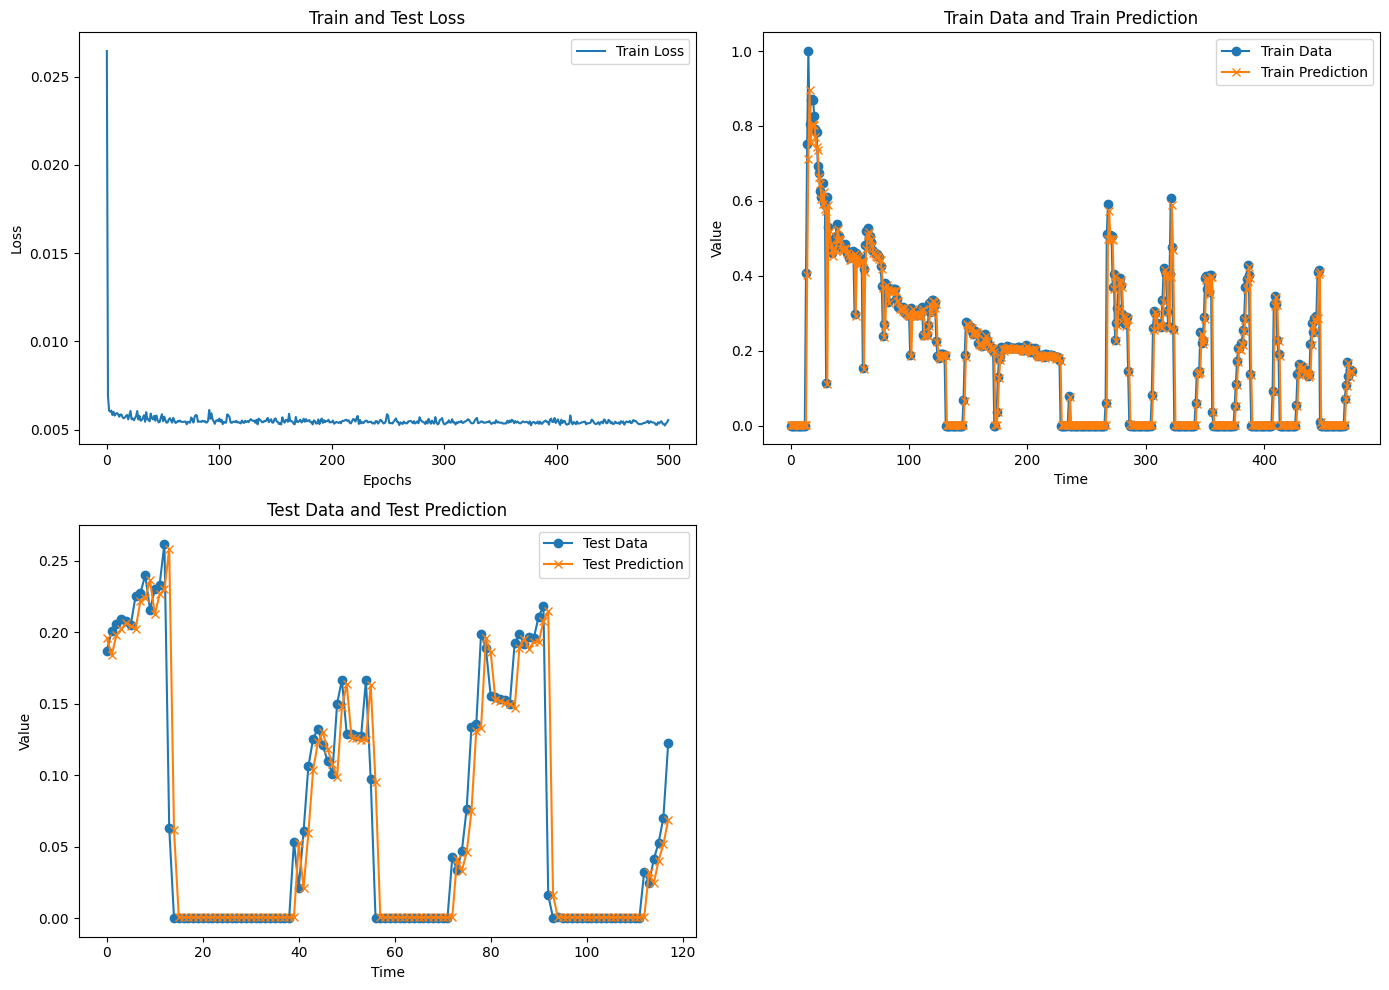

In [45]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

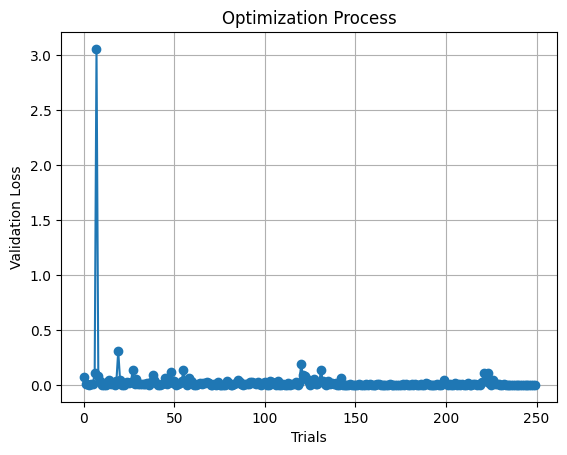

In [46]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

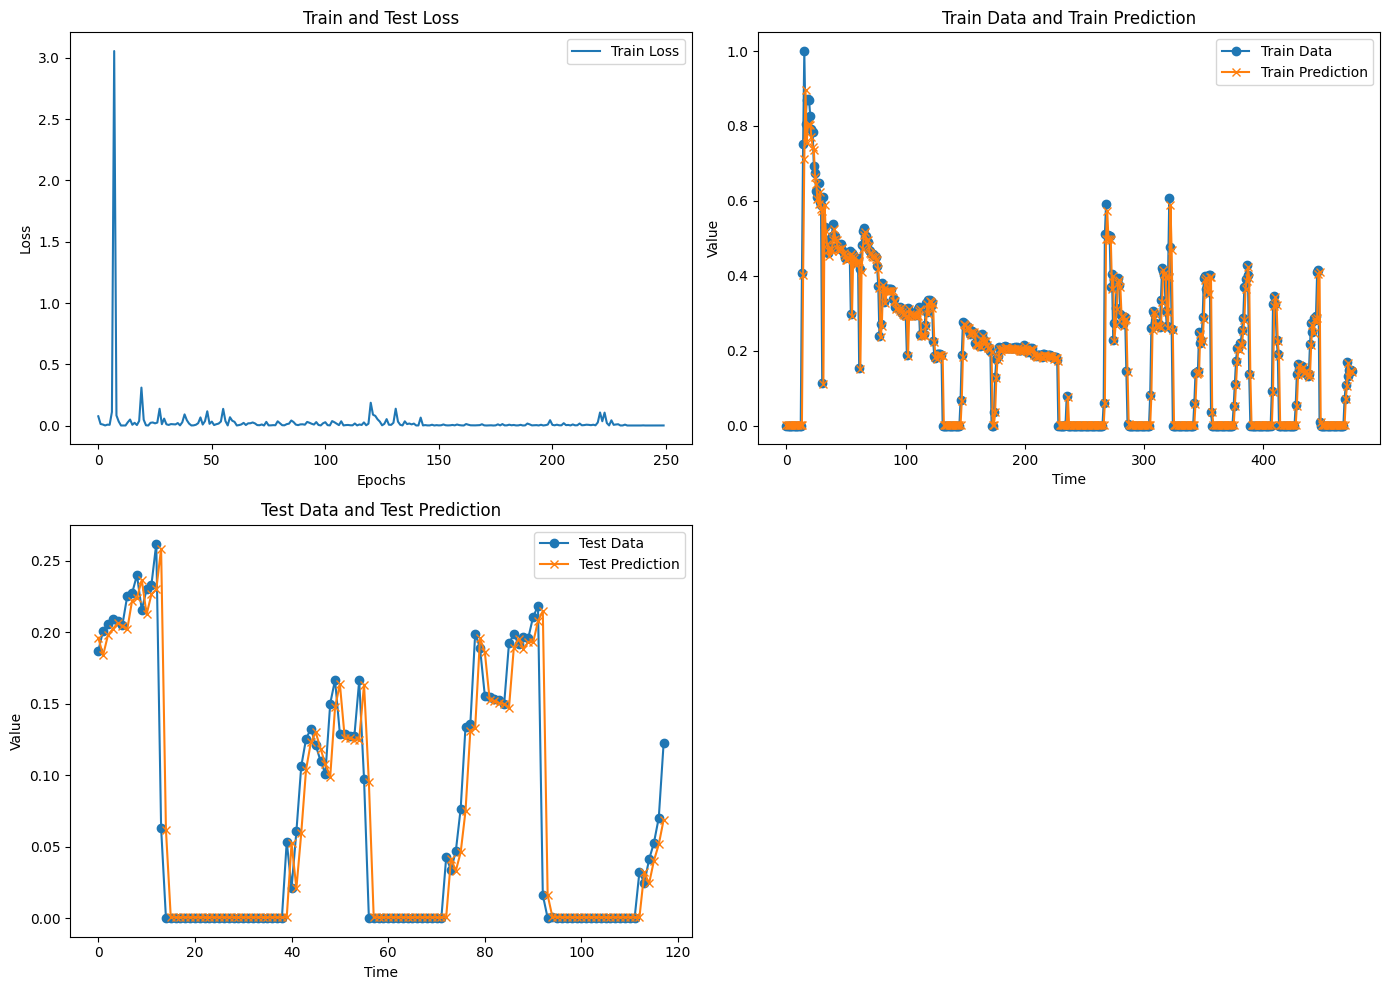

In [47]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

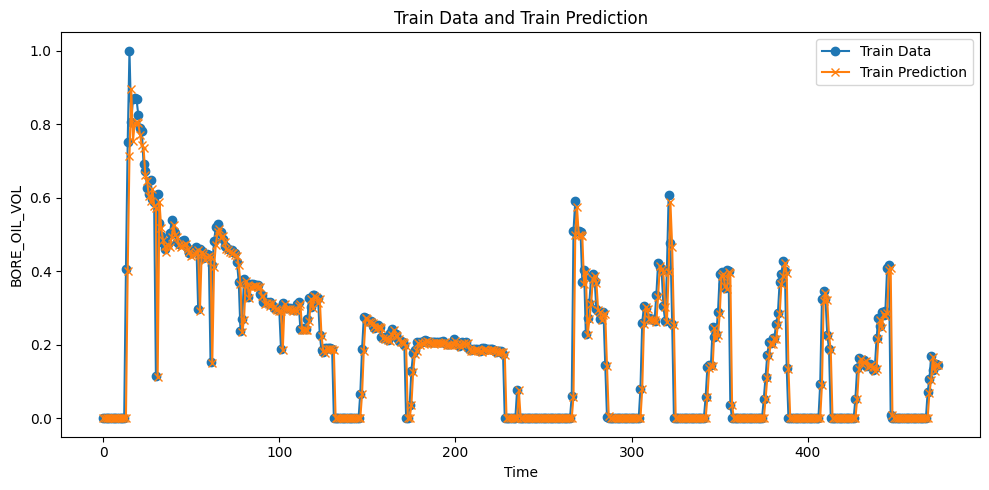

In [69]:
plt.figure(figsize=(10,5))
# Plot Test Data and Test Prediction
plt.plot(y_train, label='Train Data', marker='o')
plt.plot(y_train_pred_LSTM, label='Train Prediction', marker='x')
plt.xlabel('Time')
plt.ylabel('BORE_OIL_VOL')
plt.title('Train Data and Train Prediction')
plt.legend()

plt.tight_layout()
plt.show()

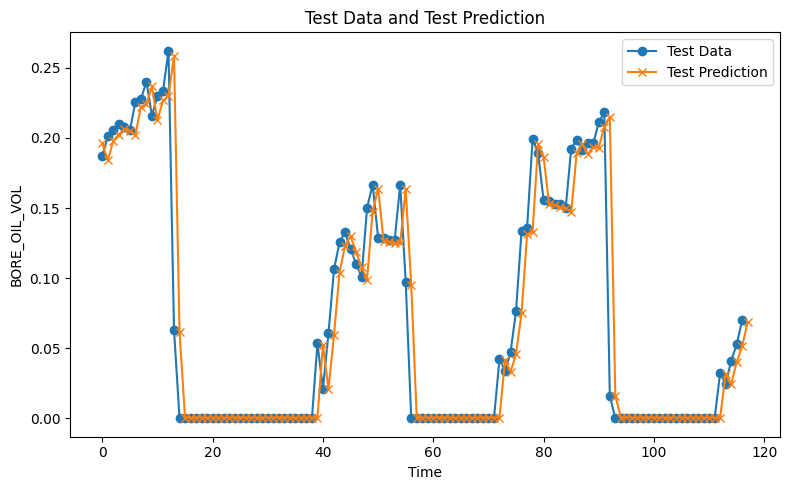

In [70]:
plt.figure(figsize=(8,5))
# Plot Test Data and Test Prediction
plt.plot(y_test[:-1], label='Test Data', marker='o')
plt.plot(y_test_pred_LSTM, label='Test Prediction', marker='x')
plt.xlabel('Time')
plt.ylabel('BORE_OIL_VOL')
plt.title('Test Data and Test Prediction')
plt.legend()

plt.tight_layout()
plt.show()

### Agora vamos criar o modelo com a melhor solução

In [48]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [49]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [50]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [51]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [52]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [53]:
# from keras.utils.vis_utils import plot_model


In [54]:
# plot_model(model_LSTM)

In [55]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [56]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [57]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.005373170462022737
Test MSE: 0.0014282662585843684


In [58]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [59]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.005288  0.001117
1  Baseline   0.005373  0.001428


In [60]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [61]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 23, 'batch_size': 20, 'n_lstm_layers': 8, 'lstm_units': 191, 'learning_rate': 0.0044478007812690165}
Trial 2: {'window_size': 33, 'batch_size': 7, 'n_lstm_layers': 18, 'lstm_units': 219, 'learning_rate': 0.0024263433575845888}
Trial 3: {'window_size': 40, 'batch_size': 11, 'n_lstm_layers': 4, 'lstm_units': 218, 'learning_rate': 0.005901877031805708}
Trial 4: {'window_size': 3, 'batch_size': 11, 'n_lstm_layers': 19, 'lstm_units': 55, 'learning_rate': 0.0009445852923767603}
Trial 5: {'window_size': 51, 'batch_size': 20, 'n_lstm_layers': 10, 'lstm_units': 59, 'learning_rate': 0.004091514003816997}
Trial 6: {'window_size': 55, 'batch_size': 8, 'n_lstm_layers': 5, 'lstm_units': 145, 'learning_rate': 0.00987589433740647}
Trial 7: {'window_size': 17, 'batch_size': 3, 'n_lstm_layers': 7, 'lstm_units': 150, 'learning_rate': 0.007707936545565757}
Trial 8: {'window_size': 36, 'batch_size': 18, 'n_lstm_layers': 17, 'lstm_units': 16